# Evaluate the Effect of Error Threshold
A decision in training is how much we should trade off between structures which are similar to the training set and those which might be unrealistic. 
We control this tradeoff by changing how large of an error we target when producing new structures.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import utils
import json

## Get the runs
We want the runs named `ttm_md-1000_thr-*`

In [2]:
runs = list(Path('../prod-runs/').glob('ttm_md-1000_thr-[0-9.]*'))
print(f'Found {len(runs)} runs')

Found 7 runs


Get only those at 300K

In [3]:
runs = [x for x in runs if 'T-' not in x.name]
print(f'Found {len(runs)} runs')

Found 6 runs


Make sure training parameters for the network were the same

In [4]:
params = json.loads((runs[0] / 'final-model' / 'params.json').read_text())
params.pop('run_dir')
for run in runs:
    my_params = json.loads((run / 'final-model' / 'params.json').read_text())
    my_params.pop('run_dir')
    assert my_params == params, f'{run} is different'

## Measure the Errors on a Hold-out Set
Get the errors for each network in force and energy for a set of structures produced by running molecular dynamics with TTM.

In [5]:
data = utils.assess_against_holdout(runs, ['energy_tolerance']).rename(columns={'energy_tolerance': 'energy_tol'}).sort_values('energy_tol')

We now have the errors and for each error tolerance

In [6]:
data

,energy_tol,n_duplicates,energy_error_per_atom-mean,energy_error_per_atom-sem,force_rmsd-mean,force_rmsd-sem,energy_error_per_atom-init-mean,energy_error_per_atom-init-sem,force_rmsd-init-mean,force_rmsd-init-sem
1,0.0010,1,0.473462,0.023784,0.166934,0.003762,0.611805,0.025899,0.295862,0.007720
3,0.0025,1,0.480485,0.025678,0.153234,0.003570,0.611805,0.025899,0.295862,0.007720
2,0.0050,2,0.847483,0.024582,0.252033,0.008028,0.611805,0.018236,0.295862,0.005436
5,0.0100,1,0.595828,0.049985,0.233876,0.008889,0.611805,0.025899,0.295862,0.007720
4,0.0150,1,1.269186,0.140444,0.275506,0.006124,0.611805,0.025899,0.295862,0.007720
0,0.0200,1,2.058108,0.133091,0.495910,0.023578,0.611805,0.025899,0.295862,0.007720


Make a figure

Text(0.5, 0, 'Target Error (meV/atom)')

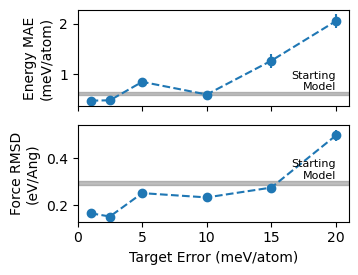

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3.5, 2.75))

axs[0].set_xlim([0, 21])
for ax, t in zip(axs, ['energy_error_per_atom', 'force_rmsd']):
    # Plot the initial model
    ax.errorbar(data['energy_tol'] * 1000, data[f'{t}-mean'], fmt='--o', yerr=data[f'{t}-sem'])
    
    # Plot the initial model
    row = data.iloc[0]
    ax.fill_between(ax.get_xlim(),
                    y1=row[f'{t}-init-mean'] + row[f'{t}-init-sem'],
                    y2=row[f'{t}-init-mean'] - row[f'{t}-init-sem'],
                   color='gray', alpha=0.5)
    ax.text(20, row[f'{t}-init-mean'] + row[f'{t}-init-sem'], 'Starting\nModel',
           ha='right', va='bottom', fontsize=8)
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[-1].set_xlabel('Target Error (meV/atom)')

Smaller error tolernaces is at least better for molecular dynamics structures sampled with TTM.

This is good, but does not show how well the model samples on its own.

## Evaluate suitability for basin hobbing
We ran MCTBP with each potential for 100 steps then evaluated the energy of the minima it proposed using TTM. 
We measure the performance of the model based on a few different metrics:
- Energy and Force error between ML and TTM for the proposed minima to measure the quality of the potential for these structures.
- Maximum force for the proposed structure, as computed with TTM. A measure of how close to the relaxed geometry we are
- Ranking performance: Whether the minima ordered by energy via ML is close to the ranking via TTM. 

In [8]:
data = utils.assess_from_mctbp_runs(runs, ['energy_tolerance']).rename(columns={'energy_tolerance': 'energy_tol'}).sort_values('energy_tol')

Could not assess /home/lward/Work/ExaLearn/fast-finedtuned-forcefields/colmena/initial/runs/ttm-md-23Mar14-163602-24b53d for ../prod-runs/ttm_md-1000_thr-0.005


Summarize all runs

In [9]:
data

,energy_tol,n_duplicates,number_sampled,energy_error-mean,energy_error-sem,force_error-mean,force_error-sem,max_force-mean,max_force-sem,tau-mean,tau-sem
1,0.0010,1,1579,32.282207,1.019637,4.946066,0.101764,2.642911,0.060444,0.442001,0.059882
3,0.0025,1,1533,37.641752,1.049878,5.213443,0.090260,2.751766,0.052648,0.510097,0.049663
2,0.0050,1,1608,120.648891,2.786785,11.340974,0.172133,4.561690,0.055583,0.052273,0.074449
5,0.0100,1,1605,70.435880,1.695377,8.590225,0.138618,4.278350,0.064712,0.155359,0.086607
4,0.0150,1,1581,129.233666,3.531328,12.216515,0.258257,5.053175,0.130531,0.094797,0.077112
0,0.0200,1,1616,26.625991,0.718212,5.409582,0.083087,2.562386,0.048452,0.532079,0.053822


Plot the errors

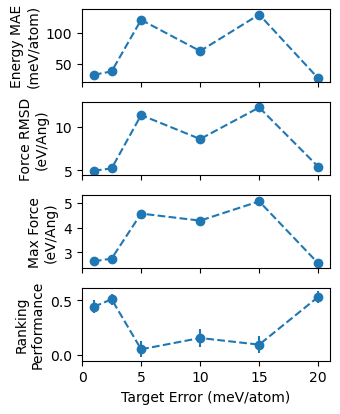

In [10]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(3.5, 4.25))

axs[0].set_xlim([0, 21])
for ax, t in zip(axs, ['energy_error', 'force_error', 'max_force', 'tau']):
    ax.errorbar(data['energy_tol'] * 1000, data[f'{t}-mean'], fmt='--o', yerr=data[f'{t}-sem'])
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[2].set_ylabel('Max Force\n(eV/Ang)')
axs[3].set_ylabel('Ranking\nPerformance')
axs[-1].set_xlabel('Target Error (meV/atom)')

fig.tight_layout()

We get poor performance with values of the target error between 5-15 meV/atom. It seems either a small tolerance (better model) or a large tolerance (sampling high-energy structures) are better. 

## Conclusion
We want a small target error. 2.5 meV/atom gives us the best performance against the holdout set and produces a model that ranks structures well.